The number of iterations (n_iter = 100, no tolerance set) and the number of initializations (n_init = 100) are set to sufficiently large s.t. stable estimates of the noise component mean, standard deviation, and weight could be derived. Most ROIs are best fitted with a 2-GMM, except for the two occipital ROIs, as demonstrated in the box plots of BIC v.s. number of components (k = 2~7) in Figure 1. While the starting points are randomly selected from the data, an alternative initialization method would be k-means, which tends to converge faster to a solution by grouping the data points into components based on their similarity. However, k-means favors evenly distributed components incompatible with this case where the mean SUVR measurements of the AD and control subpopulations give overlapping and unbalanced components; k-means would get stuck in a local minimum and fail to attain a final BIC lower than that using random from data start points in all ROIs.

In addition, bootstrapping was aemployed to assess the variability and robustness of the GMM parameter estimates. Bootstrapping allows us to generate multiple resamples from the original dataset and refit the model on each resample, thereby providing a distribution of the parameter estimates. This approach helps in understanding the stability and confidence in our estimates by constructing confidence intervals and standard errors. The minimum number of initializations and iterations needed to derive stable estimates are used to speed up the process, as shown in Figure 2, with the aforementioned number of components and the random from data initialization method. The final estimates with 5000 resamples are listed in Table 1, included the 95% bias-corrected and accelerated confidence intervals. 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
from matplotlib.lines import Line2D
from sklearn.model_selection import GridSearchCV 
from sklearn.exceptions import ConvergenceWarning
import warnings
sys.path.append('../') 

In [60]:
cpath = '/Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/cap/dataexp/pySuStaIn/dat/'
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]  
 
lftp = pd.read_csv(cpath+'lftp.csv')
df = pd.read_csv(cpath+'wide_data.csv')
df = df[df.dx.isin(['EOAD','CN'])]
zdf = pd.read_csv(cpath+'zdata.csv')
zdata = zdf.loc[:,lobes].values
dat = df.loc[:,lobes].values 
cn_idx = df.index[df['dx'] == 'CN']
eoad_idx = df.index[df['dx'] == 'EOAD'] 


## gmm z-score 


https://scikit-learn.org/stable/modules/mixture.html 

covariances: n_feature = 1

assume k component

(n_components,)                        if 'spherical', dim = k, each component has own single var = own sd

(n_features, n_features)               if 'tied',      dim = 1, all components has same general cov = same sd

(n_components, n_features)             if 'diag',      dim = k, each component has own diagnoal cov = own sd

(n_components, n_features, n_features) if 'full'       dim = k, each component has own general cov = own sd


In [6]:
init = 'random_from_data'

## best # of GMM components 

In [7]:
from sklearn.mixture import GaussianMixture 

In [8]:
#inits = ['random_from_data','kmeans',]#'random'
n_components_range = range(1, 6) 
bestk_df = pd.DataFrame(columns=['ROI', 'K', 'BIC','mean1','weight1','sd1']) 
for roi_idx, roi_data in enumerate(dat.T):  
    bic_scores = [] 
    for n_components in n_components_range:
        gmm_model =  GaussianMixture(n_components=n_components,
                                    init_params='random_from_data',
                                    covariance_type='full',
                                    n_init=100,
                                    random_state=42)
        gmm_model.fit(roi_data.reshape(-1, 1))  
        means = gmm_model.means_.flatten()
        sds =  np.sqrt(gmm_model.covariances_.flatten())
        weights = gmm_model.weights_.flatten()
        c1_idx = np.argmin(means)  
        bic_score = gmm_model.bic(roi_data.reshape(-1, 1)) 
        # Store the results for each component
        n_results = pd.DataFrame({'ROI': lobes[roi_idx],
                                    'K': n_components,
                                    'BIC': bic_score,
                                    'mean1':[means[c1_idx]], 
                                    'weight1':weights[c1_idx],
                                    'sd1':sds[c1_idx] })
        bestk_df = pd.concat([bestk_df, n_results], ignore_index=True) 
bestk_df.head(2)
#bestk_df.to_csv(cpath+'bestk_paraminit.csv')


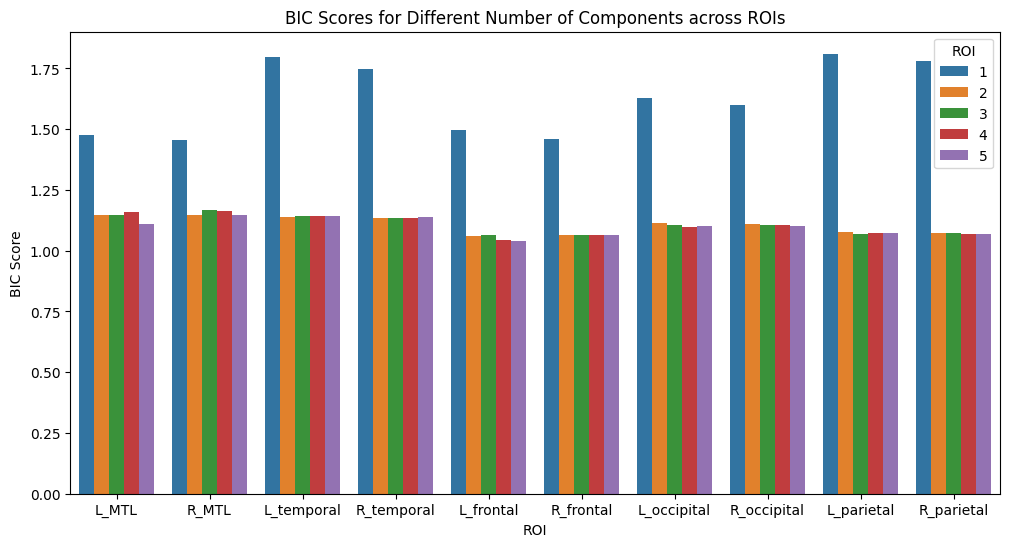

In [83]:
 
plt.figure(figsize=(12, 6))
sns.barplot(x='ROI', y='mean1', hue='K', data=bestk_df)
plt.xlabel('ROI')
plt.ylabel('BIC Score')
plt.legend()
plt.title('BIC Scores for Different Number of Components across ROIs')
plt.legend(title='ROI')
plt.show()


## min n_iter and n_init  

In [10]:
#for n_i in np.unique(np.rint(np.logspace(0, 2, 40)).astype(int)):
#for n_it in np.arange(1,201,5):


In [11]:
np.random.seed(42)
 
rand10 = np.random.randint(0, 1204, size=10)
rand10


array([1126,  860, 1130, 1095, 1044,  121,  466,  330,   87, 1123])

### generate df

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning) 
init_df = pd.DataFrame(columns=['ROI','BIC','mean1','weight1','sd1','n_init'])   

compk = dict(zip(lobes,[2 for i in range(10)]))
compk['L_occipital'] = 3
compk['R_occipital'] = 3

for roi_idx, roi_data in enumerate(dat.T):  
    bic_scores = [] 
    for n_i in np.unique(np.rint(np.logspace(0, 2.4, 16)).astype(int)):
        for n_it in np.arange(1,201,5):
            for i in range(10):
                gmm_model = GaussianMixture(n_components=compk[lobes[roi_idx]],
                                            init_params=init,
                                            covariance_type='full',
                                            n_init=n_i,
                                            max_iter = n_it,
                                            tol=0,
                                            random_state=rand10[i])
                gmm_model.fit(roi_data.reshape(-1, 1))   
                bic_score = gmm_model.bic(roi_data.reshape(-1, 1))  
                means = gmm_model.means_.flatten()
                sds =  np.sqrt(gmm_model.covariances_.flatten())
                weights = gmm_model.weights_.flatten()
                c1_idx = np.argmin(means)    
                n_results = pd.DataFrame({'ROI': lobes[roi_idx], 
                                            'BIC': bic_score,
                                            'mean1':[means[c1_idx]], 
                                            'weight1':weights[c1_idx],
                                            'sd1':sds[c1_idx],
                                            'n_init':n_i,
                                            'n_iter':n_it})
                init_df = pd.concat([init_df, n_results], ignore_index=True)   
init_df.head(2)
init_df.to_csv('initdf.csv')


# plot param 

## heatmap

In [ ]:
#heatmap 

# Pivot the DataFrame to get the heatmap data
heatmap_data = init_df.pivot_table(index='n_init', columns='n_iter', values='BIC', aggfunc=np.std)

# Min-max standardize the BIC values
heatmap_data_norm = (heatmap_data - heatmap_data.min().min()) / (heatmap_data.max().max() - heatmap_data.min().min())

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_norm, cmap='viridis', vmin=0,vmax=1)# annot=False, fmt=".2f",
plt.xlabel('Number of Iterations (n_iter)')
plt.ylabel('Number of Initializations (n_init)')
plt.title('Heatmap of Min-Max Standardized BIC Scores')
plt.show()

## lineplots

In [19]:
initdf = pd.read_csv(cpath+'initdf.csv').drop(columns=["Unnamed: 0.1","Unnamed: 0"])
initdf.head(2)

,ROI,BIC,mean1,weight1,sd1,n_init,n_iter
0,L_MTL,311.690579,1.067386,0.189329,0.061075,1,1.0
1,L_MTL,252.494670,1.131452,0.358003,0.084662,1,1.0


### n_init

In [21]:
finit = initdf[initdf.n_iter == 56]
finit

,ROI,BIC,mean1,weight1,sd1,n_init,n_iter
110,L_MTL,239.159248,1.148035,0.350885,0.096956,1,56.0
111,L_MTL,239.158338,1.148233,0.351921,0.097184,1,56.0
112,L_MTL,239.159199,1.148422,0.352897,0.097399,1,56.0
113,L_MTL,239.159723,1.147990,0.350646,0.096903,1,56.0
114,L_MTL,239.160840,1.147908,0.350213,0.096808,1,56.0
...,...,...,...,...,...,...,...
17995,R_parietal,774.453584,1.070537,0.367009,0.064116,251,56.0
17996,R_parietal,774.453584,1.070537,0.367009,0.064116,251,56.0
17997,R_parietal,774.453584,1.070537,0.367009,0.064116,251,56.0
17998,R_parietal,774.453584,1.070537,0.367009,0.064116,251,56.0


#### BIC

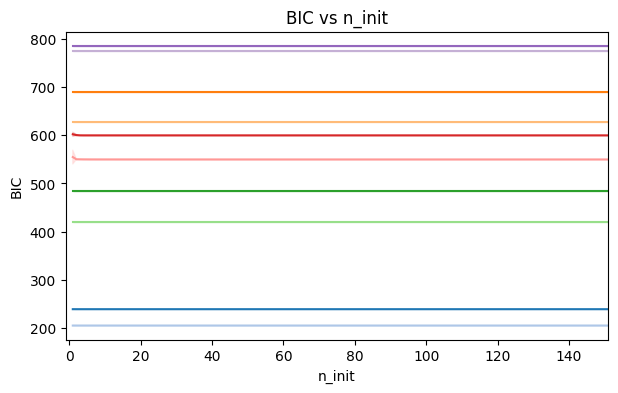

In [32]:
finit = initdf[initdf.n_iter == 56]
plt.figure(figsize=(7, 4))
sns.lineplot(data=finit, x='n_init', y='BIC', hue='ROI', errorbar='sd', palette='tab20',legend=False)
plt.title('BIC vs n_init')
plt.xlabel('n_init')
plt.ylabel('BIC')
plt.xlim([-1,151])
#plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


#### mean

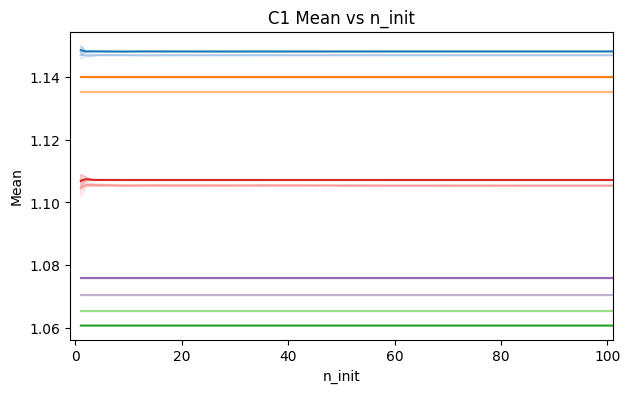

In [38]:
 
plt.figure(figsize=(7, 4))
sns.lineplot(data=finit, x='n_init', y='mean1', hue='ROI', errorbar='sd',   palette='tab20',legend=False)
plt.title('C1 Mean vs n_init')
plt.xlabel('n_init')
plt.ylabel('Mean')
plt.xlim([-1,101])
#plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


#### sd

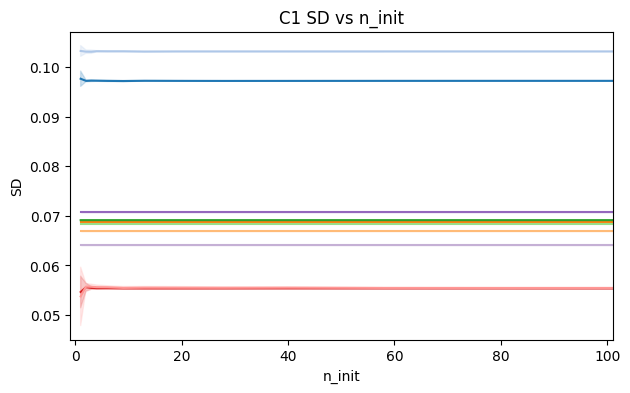

In [39]:
 
plt.figure(figsize=(7, 4))
sns.lineplot(data=finit, x='n_init', y='sd1', hue='ROI', errorbar='sd',   palette='tab20',legend=False)
plt.title('C1 SD vs n_init')
plt.xlabel('n_init')
plt.ylabel('SD')
plt.xlim([-1,101])
#plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


#### weight

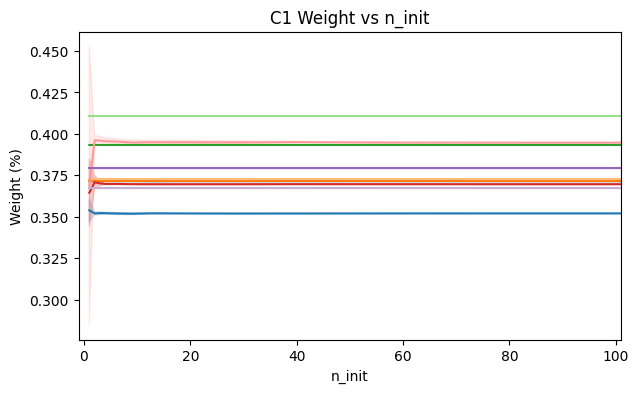

In [40]:
 
plt.figure(figsize=(7, 4))
sns.lineplot(data=finit, x='n_init', y='weight1', hue='ROI', errorbar='sd',   palette='tab20',legend=False)
plt.title('C1 Weight vs n_init')
plt.xlabel('n_init')
plt.ylabel('Weight (%)')
plt.xlim([-1,101])
#plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


### max_iter

In [141]:
initdf.n_init.unique()

array([  1,   2,   3,   4,   6,   9,  13,  19,  28,  40,  58,  83, 120,
       174, 251])

In [48]:
initdf = pd.read_csv(cpath+'initdf.csv').drop(columns=["Unnamed: 0.1","Unnamed: 0"])
minit = initdf[initdf.n_init == 83]
minit.head(2)

,ROI,BIC,mean1,weight1,sd1,n_init,n_iter
1320,L_MTL,274.916986,1.201377,0.507745,0.133492,83,1.0
1321,L_MTL,282.102597,1.210890,0.524957,0.141103,83,1.0


In [51]:
minit.n_iter.unique()

array([ 1.,  6., 11., 16., 21., 26., 31., 36., 41., 46., 51., 56.])

#### BIC

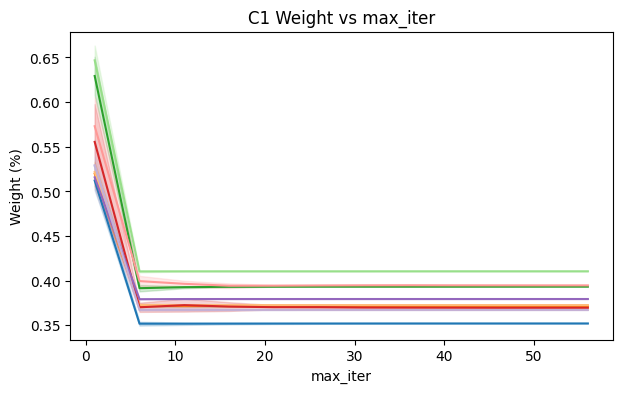

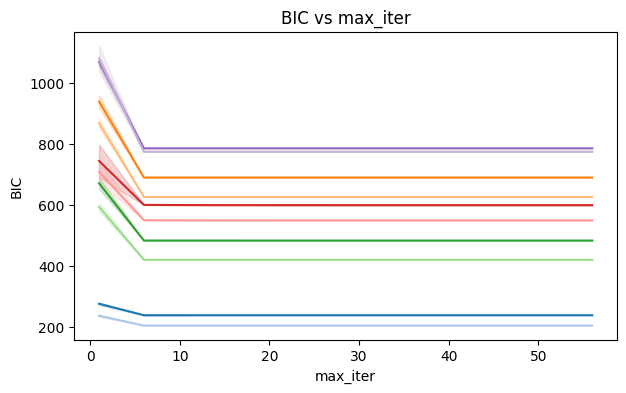

In [58]:
 
plt.figure(figsize=(7, 4))
sns.lineplot(data=minit, x='n_iter', y='BIC', hue='ROI', errorbar='sd',   palette='tab20',legend=False)
plt.title('BIC vs max_iter')
plt.xlabel('max_iter')
plt.ylabel('BIC') 
#plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


#### Mean

In [144]:
minit['z'] = abs((1 - minit['mean1'])/minit['sd1'])

/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_92923/1377243652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minit['z'] = abs((1 - minit['mean1'])/minit['sd1'])


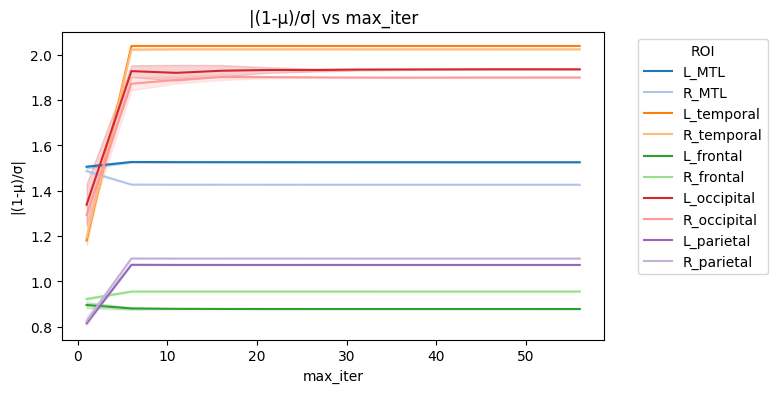

In [147]:

plt.figure(figsize=(7, 4))
sns.lineplot(data=minit, x='n_iter', y='z', hue='ROI', errorbar='sd', palette='tab20',legend=True)
plt.title('|(1-μ)/σ| vs max_iter')
plt.xlabel('max_iter')
plt.ylabel('|(1-μ)/σ|') 
plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


#### SD

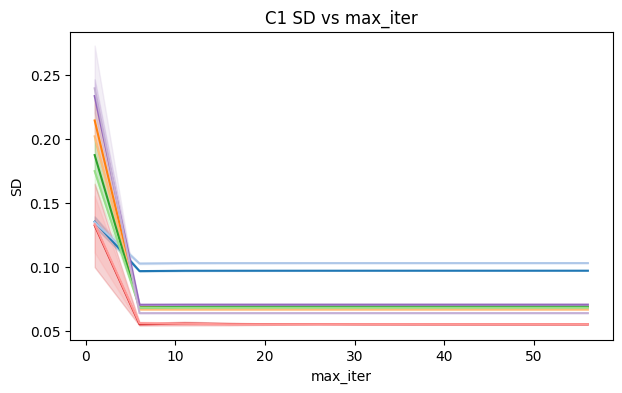

In [56]:
 
plt.figure(figsize=(7, 4))
sns.lineplot(data=minit, x='n_iter', y='sd1', hue='ROI', errorbar='sd', palette='tab20',legend=False)
plt.title('C1 SD vs max_iter')
plt.xlabel('max_iter')
plt.ylabel('SD') 
#plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


#### Weight

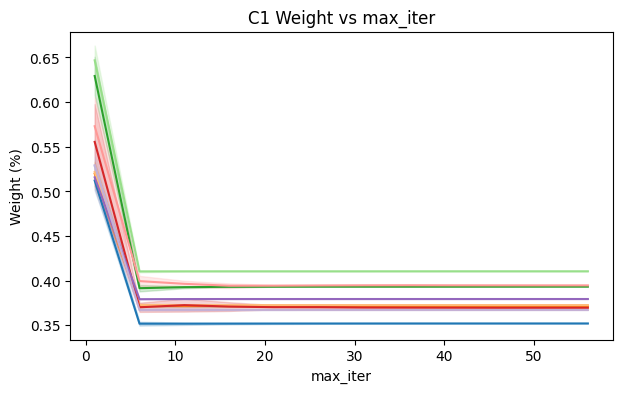

In [53]:
 
plt.figure(figsize=(7, 4))
sns.lineplot(data=minit, x='n_iter', y='weight1', hue='ROI', errorbar='sd',   palette='tab20',legend=False)
plt.title('C1 Weight vs max_iter')
plt.xlabel('max_iter')
plt.ylabel('Weight (%)') 
#plt.legend(title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show()


## param choice plot

### components  

In [65]:
bestk_df = pd.read_csv(cpath+'bestk_paraminit.csv').drop(columns='Unnamed: 0')
bestk_df.head()

,ROI,K,BIC,mean1,weight1,sd1
0,L_MTL,1,351.525419,1.477203,1.000000,0.323884
1,L_MTL,2,239.177725,1.148133,0.354803,0.097291
2,L_MTL,3,255.102848,1.147558,0.367365,0.098855
3,L_MTL,4,273.977746,1.159822,0.394946,0.108002
4,L_MTL,5,290.289623,1.110074,0.162995,0.072848


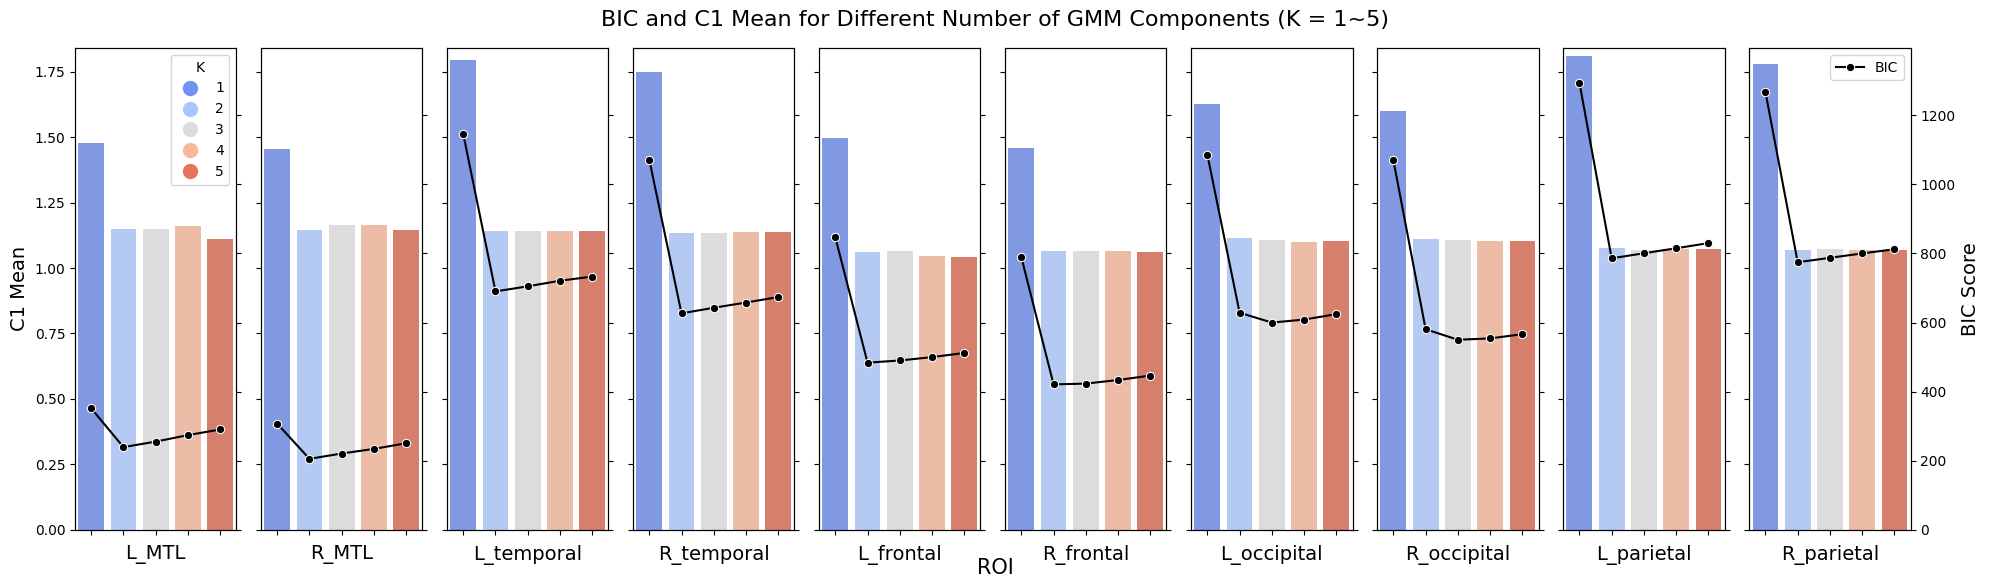

In [121]:
# Define the y-axis limits
mean1_min, mean1_max = 0, bestk_df['mean1'].max()+0.03
bic_min, bic_max = 0, bestk_df['BIC'].max() + 100

# Get the unique ROIs
rois = bestk_df['ROI'].unique()

# Create a figure with 10 subplots in one row
fig, axes = plt.subplots(1, len(rois), figsize=(20, 6), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1)

# Define the color palette for the bars
palette = sns.color_palette('coolwarm', 5)

# Plot each ROI in a separate subplot
for i, roi in enumerate(rois):
    ax1 = axes[i]
    roi_data = bestk_df[bestk_df['ROI'] == roi]

    # Plot the means with a barplot
    bar_plot = sns.barplot(x='K', y='mean1', data=roi_data, ax=ax1, palette=palette, dodge=True)
    ax1.set_ylim(mean1_min, mean1_max)
    ax1.set_title('')
    if i == 0:
        ax1.set_ylabel('C1 Mean',fontsize=14)
    else:
        ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax1.set_xticklabels([])
    ax1.set_xlabel(roi, fontsize=14)
    
    # Adjust the x-ticks position for the line plot
    x_ticks = [tick.get_x() + tick.get_width() / 2 for tick in bar_plot.patches[:len(roi_data['K'].unique())]]

    # Create a second y-axis to plot the BIC scores
    ax2 = ax1.twinx()
    sns.lineplot(x=x_ticks, y=roi_data['BIC'], ax=ax2, marker='o', color='black', label='BIC')
    ax2.set_ylim(bic_min, bic_max)
    ax2.set_xlim(-0.5, len(roi_data['K'].unique()) - 0.5)  # Adjust x-axis limits to match bars
    #ax2.set_xticks(x_ticks)
    #ax2.set_xticklabels(roi_data['K'].unique(), fontsize=14)
    if i == len(rois) - 1:
        ax2.set_ylabel('BIC Score', fontsize=14)
    else:
        ax2.set_ylabel('')
        ax2.set_yticklabels([])  # Remove BIC y-axis labels
        ax2.get_legend().remove()

    # Add legend for the number of components (hue) in the top left corner of the first subplot
    if i == 0:
        handles = [plt.Line2D([0], [0], marker='o', color=palette[j], linestyle='', markersize=10) for j in range(len(roi_data['K'].unique()))]
        labels = [str(k) for k in roi_data['K'].unique()]
        ax1.legend(handles, labels, loc='upper right', title='K')
   # else:
    #    ax1.get_legend().remove()

# Add overall title and x-axis label
fig.suptitle('BIC and C1 Mean for Different Number of GMM Components (K = 1~5)', fontsize=16)
fig.text(0.5, 0.04, 'ROI', ha='center', fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()


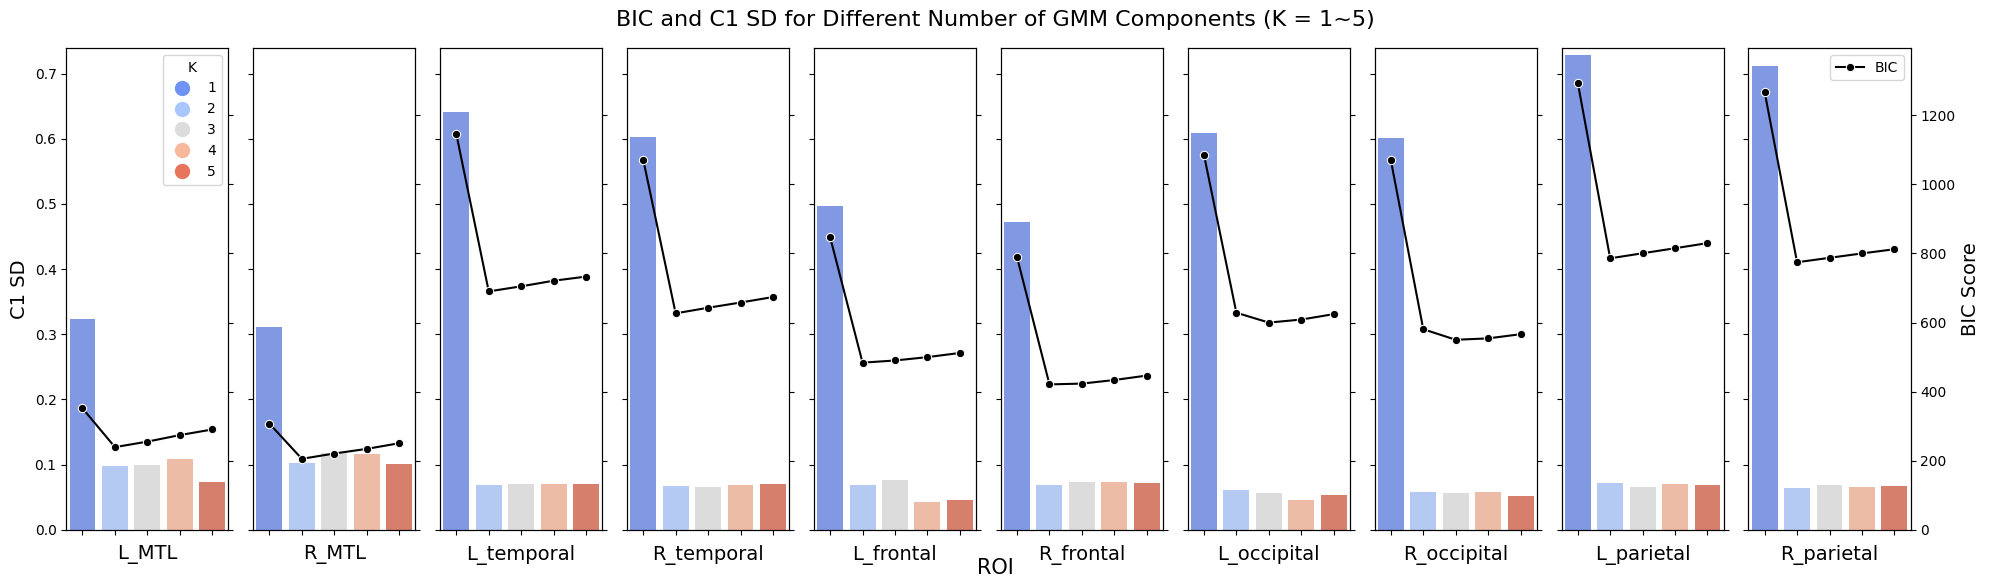

In [122]:
# Define the y-axis limits
mean1_min, mean1_max = 0, bestk_df['sd1'].max()+0.01
bic_min, bic_max = 0, bestk_df['BIC'].max() + 100

# Get the unique ROIs
rois = bestk_df['ROI'].unique()

# Create a figure with 10 subplots in one row
fig, axes = plt.subplots(1, len(rois), figsize=(20, 6), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1)

# Define the color palette for the bars
palette = sns.color_palette('coolwarm', 5)

# Plot each ROI in a separate subplot
for i, roi in enumerate(rois):
    ax1 = axes[i]
    roi_data = bestk_df[bestk_df['ROI'] == roi]

    # Plot the means with a barplot
    bar_plot = sns.barplot(x='K', y='sd1', data=roi_data, ax=ax1, palette=palette, dodge=True)
    ax1.set_ylim(mean1_min, mean1_max)
    ax1.set_title('')
    if i == 0:
        ax1.set_ylabel('C1 SD',fontsize=14)
    else:
        ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax1.set_xticklabels([])
    ax1.set_xlabel(roi, fontsize=14)
    
    # Adjust the x-ticks position for the line plot
    x_ticks = [tick.get_x() + tick.get_width() / 2 for tick in bar_plot.patches[:len(roi_data['K'].unique())]]

    # Create a second y-axis to plot the BIC scores
    ax2 = ax1.twinx()
    sns.lineplot(x=x_ticks, y=roi_data['BIC'], ax=ax2, marker='o', color='black', label='BIC')
    ax2.set_ylim(bic_min, bic_max)
    ax2.set_xlim(-0.5, len(roi_data['K'].unique()) - 0.5)  # Adjust x-axis limits to match bars
    #ax2.set_xticks(x_ticks)
    #ax2.set_xticklabels(roi_data['K'].unique(), fontsize=14)
    if i == len(rois) - 1:
        ax2.set_ylabel('BIC Score', fontsize=14)
    else:
        ax2.set_ylabel('')
        ax2.set_yticklabels([])  # Remove BIC y-axis labels
        ax2.get_legend().remove()

    # Add legend for the number of components (hue) in the top left corner of the first subplot
    if i == 0:
        handles = [plt.Line2D([0], [0], marker='o', color=palette[j], linestyle='', markersize=10) for j in range(len(roi_data['K'].unique()))]
        labels = [str(k) for k in roi_data['K'].unique()]
        ax1.legend(handles, labels, loc='upper right', title='K')
   # else:
    #    ax1.get_legend().remove()

# Add overall title and x-axis label
fig.suptitle('BIC and C1 SD for Different Number of GMM Components (K = 1~5)', fontsize=16)
fig.text(0.5, 0.04, 'ROI', ha='center', fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()


In [133]:
# Create the 'z' column
bestk_df['z'] = np.abs((1 - bestk_df['mean1']) / bestk_df['sd1'])


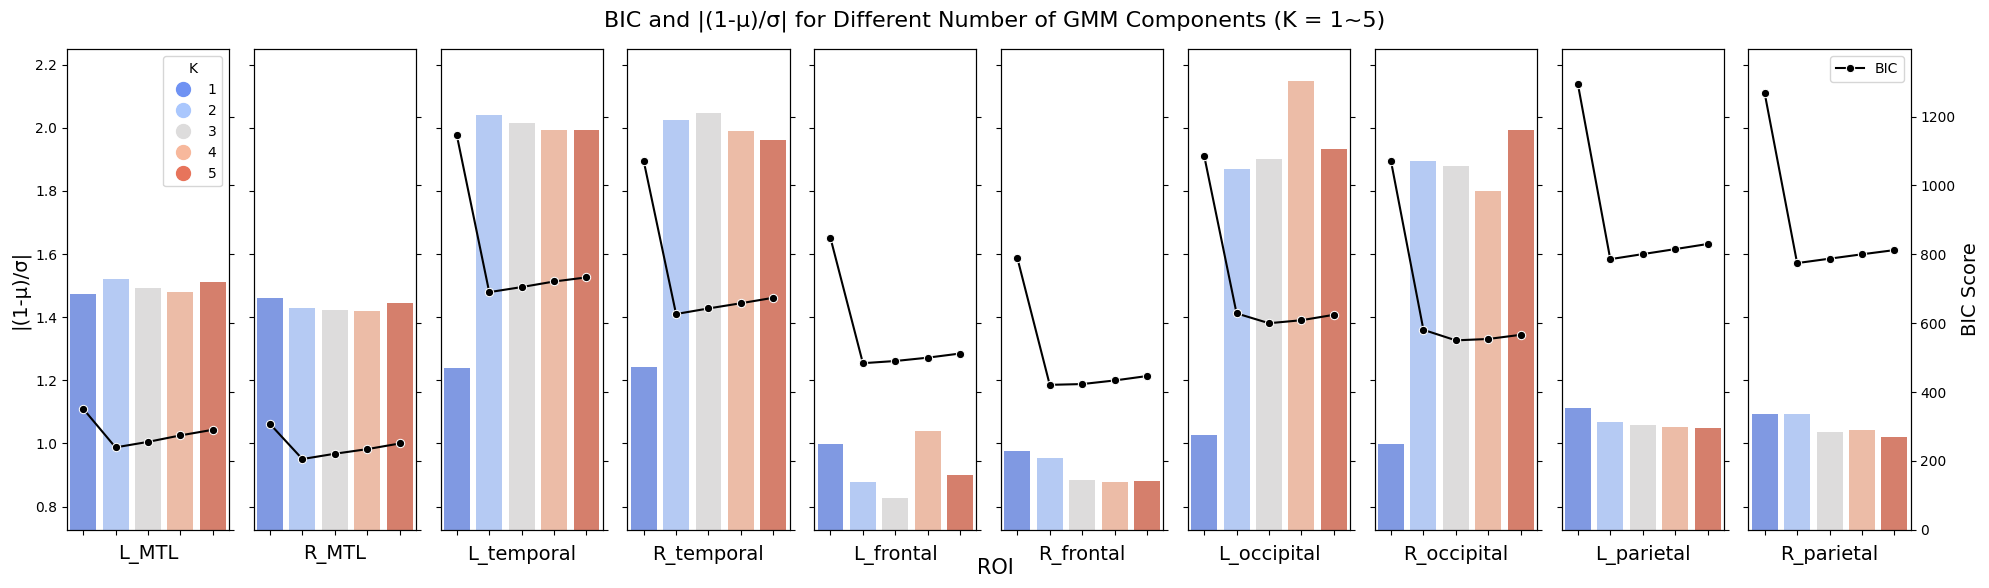

In [136]:
# Define the y-axis limits
zmin, zmax = bestk_df['z'].min()-0.1, bestk_df['z'].max()+0.1
    # Define the y-axis limits
mean1_min, mean1_max = 0, bestk_df['sd1'].max()+0.01
bic_min, bic_max = 0, bestk_df['BIC'].max() + 100

# Get the unique ROIs
rois = bestk_df['ROI'].unique()

# Create a figure with 10 subplots in one row
fig, axes = plt.subplots(1, len(rois), figsize=(20, 6), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.1)

# Define the color palette for the bars
palette = sns.color_palette('coolwarm', 5)

# Plot each ROI in a separate subplot
for i, roi in enumerate(rois):
    ax1 = axes[i]
    roi_data = bestk_df[bestk_df['ROI'] == roi]

    # Plot the means with a barplot
    bar_plot = sns.barplot(x='K', y='z', data=roi_data, ax=ax1, palette=palette, dodge=True)
    ax1.set_ylim(zmin, zmax)
    ax1.set_title('')
    if i == 0:
        ax1.set_ylabel('|(1-μ)/σ|',fontsize=1)
    else:
        ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax1.set_xticklabels([])
    ax1.set_xlabel(roi, fontsize=14)
    
    # Adjust the x-ticks position for the line plot
    x_ticks = [tick.get_x() + tick.get_width() / 2 for tick in bar_plot.patches[:len(roi_data['K'].unique())]]

    # Create a second y-axis to plot the BIC scores
    ax2 = ax1.twinx()
    sns.lineplot(x=x_ticks, y=roi_data['BIC'], ax=ax2, marker='o', color='black', label='BIC')
    ax2.set_ylim(bic_min, bic_max)
    ax2.set_xlim(-0.5, len(roi_data['K'].unique()) - 0.5)  # Adjust x-axis limits to match bars
    #ax2.set_xticks(x_ticks)
    #ax2.set_xticklabels(roi_data['K'].unique(), fontsize=14)
    if i == len(rois) - 1:
        ax2.set_ylabel('BIC Score', fontsize=14)
    else:
        ax2.set_ylabel('')
        ax2.set_yticklabels([])  # Remove BIC y-axis labels
        ax2.get_legend().remove()

    # Add legend for the number of components (hue) in the top left corner of the first subplot
    if i == 0:
        handles = [plt.Line2D([0], [0], marker='o', color=palette[j], linestyle='', markersize=10) for j in range(len(roi_data['K'].unique()))]
        labels = [str(k) for k in roi_data['K'].unique()]
        ax1.legend(handles, labels, loc='upper right', title='K')
   # else:
    #    ax1.get_legend().remove()

# Add overall title and x-axis label
fig.suptitle('BIC and |(1-μ)/σ| for Different Number of GMM Components (K = 1~5)', fontsize=16)
fig.text(0.5, 0.04, 'ROI', ha='center', fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()
